## Simulation of a pendulum in python

Since we love simulating stuff in python and since (to the best of my knowledge) there exists no closed form solution for the exact non-linear pendulum equation, we are well motivated to write a few lines of code for a simulation.

We use the **numpy** package for the math, the **PIL** package for manipuating images and **pyplot** for making plots.

In [9]:
#import packages we will need
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

### The pendulum
The pendulum has one degree of freedom which is most naturally described by an angle which we will call theta.
![GitHub Logo](pendulum_image.png)

### Initial condition
If we know the angle and the angular velocity at any moment in time we can (in principle) precisely calculate the past and the future of the pendulum's dynamic. In order to start our simulation it is therefore enough to choose an initial angle ```theta_init``` and angular velocity ```theta_d_init```.



In [3]:
#---initial condition ---
theta_init=np.pi/3
theta_d_init=0

### Draw the pendulum
We write the function ```draw_pendulum``` that draws the pendulum for a given angle ```theta```. We add default arguments for the image width ```w```, image height ```h```, mass ```m```, length ```l``` and gravity ```g```. 

In [4]:
def draw_pendulum(theta,w=200,h=200,m=1,l=1):
	#create image with width=w and height=h
	img = Image.new("RGB", (w, h), "white")
	#convert the length of the pendulum to some image units
	L=int(0.4*h*l)
	#define a diameter for the pendulums mass
	d=int(0.02*h)*m**(1/3)
	#create the draw objects of the image
	draw = ImageDraw.Draw(img)
	#calculate the cartesian coordinates
	x0=int(w/2)
	y0=int(h/2)
	x=x0+L*np.sin(theta)
	y=y0+L*np.cos(theta)
	#draw the pendulum
	draw.line([(x0,y0),(x,y)],fill=(0,0,0),width=1)
	draw.ellipse([(x-d,y-d),(x+d,y+d)], fill=(0,0,255), outline=None)
	return img

In [10]:
#--example of draw_pendulum()----
img=draw_pendulum(theta_init)
img.show()

### Calculate the energy
We write the function ```get_energy``` that calculates the potential and kinetic energy of the pendulum's mass given the angle ```theta``` and the angular velocity ```theta_d```. The potential energy is calculated by
$$
e_{pot}=-mgy, \quad y=l \cos(\theta)
$$
and the formula for the kinetic energy is given by
$$
e_{kin}=\frac{m}{2}l^2\dot{\theta}^2.
$$

In [11]:
def get_energy(theta,theta_d,m=1,l=1,g=10):
	#the height of the mass
	y=l*np.cos(theta)
	#potential energy
	e_pot=-m*g*y
	#kinetic energy
	e_kin=m/2*(l*theta_d)**2
	return e_pot,e_kin

In [12]:
#--example of get_energy()----
e_pot,e_kin=get_energy(theta_init,theta_d_init)
print('potential energy: '+str(e_pot)[:5])
print('kinetic energy: '+str(e_kin)[:5])

potential energy: -5.00
kinetic energy: 0.0


### Calculate the trajectory
This part is the core of the simulation. For a given initial state ```(theta_init,theta_d_init)``` we aim to calculate all future states. Physics will give us the corresponding differential equation for the time dependent angle $\theta(t)$. We apply Newton's second law for the pendulum's mass and obtain
$$
\frac{d^2\theta(t)}{dt^2}=-\frac{g}{l}\sin\big(\theta(t)\big).
$$
Note that $\frac{d^2\theta(t)}{dt^2}$ is the angular accelration and the angular velocity is written as $\frac{d\theta(t)}{dt}$.
The power of this numeric simulation is, that we approximate the time-continuum by discrete time steps $\Delta t$. The most simple way to do so is called Eulers rule which states that given the state at any time $t_0$ we can cacluate the state at the time $t_0+\Delta t$ via the rule
$$
\frac{d\theta(t_0+\Delta t)}{dt}= \frac{d\theta(t_0)}{dt}+\Delta t \frac{d^2\theta(t_0)}{dt^2}=\frac{d\theta(t_0)}{dt}-\Delta t \frac{g}{l}\sin\big(\theta(t_0)\big)
$$
$$
\theta(t_0+\Delta t)=\theta(t_0)+ \Delta t \frac{d\theta(t_0)}{dt}.
$$
If you wan't to implement more sophisticated approximations, you might be interested in the familly of
[Runge-Kutta methods](https://en.wikipedia.org/wiki/Runge–Kutta_methods).

The function ```calculate_trajectory``` calculates the trajectory of states of ```n_iter``` points. The smaller the time step ```dt``` the more precise is the approximation. The downside is however that the program takes longer to calculate the simulation.

In [13]:
def calculate_trajectory(theta_init,theta_d_init,n_iter=1000,dt=0.01,g=10,l=1):
	phase_traject=np.zeros((n_iter,2))#phase-space trajectory
	phase_traject[0,:]=np.array([theta_init,theta_d_init])

	for i in range(n_iter-1):
		theta_dd=-g/l*np.sin(phase_traject[i,0])
		phase_traject[i+1,1]=phase_traject[i,1]+dt*theta_dd
		phase_traject[i+1,0]=phase_traject[i,0]+dt*phase_traject[i,1]
	return phase_traject

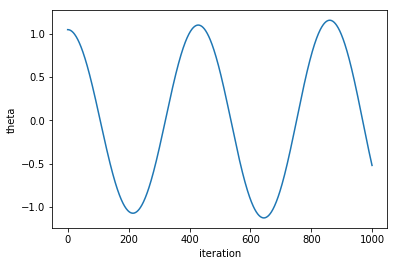

In [14]:
#---example of calculate_traject()
dt=0.005
n_iter=1000
phase_traject=calculate_trajectory(theta_init,theta_d_init,dt=dt,n_iter=n_iter)
plt.plot(phase_traject[:,0])
plt.ylabel('theta')
plt.xlabel('iteration')
plt.show()

### Energy conservation
Our physical system, the pendulum, does not dissipate any energy. Hence its total energy (potential plus kinetic) should be conserved over time. Let's check this!

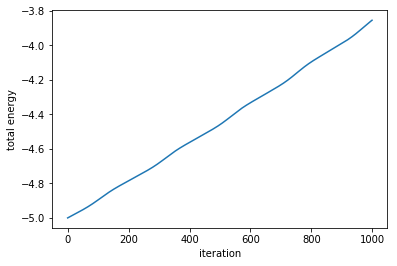

In [16]:
#--example: get energy of trajectory
total_energy=[]
for i in range(phase_traject.shape[0]):
	e_pot,e_kin=get_energy(phase_traject[i,0],phase_traject[i,1])
	total_energy.append(e_pot+e_kin)	
plt.plot(total_energy)
plt.ylabel('total energy')
plt.xlabel('iteration')
plt.show()

Unfortunatelly, we observe that energy is NOT conserved!? This is, because our discrete time approximation is not good enough. Either we use a better approximation method or we make smaller time steps. Here we do the latter and increase the number of time steps by a factor of 10. Indeed we find the the energy remains almost constant (compare the scale of the y-axis)!

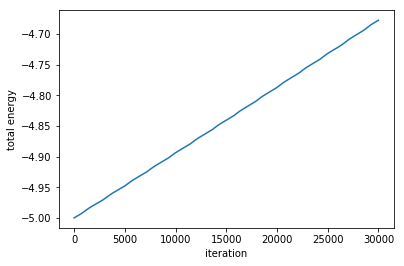

In [41]:
#we increase the number of time steps by a factor of 10
dt=0.0005
n_iter=30000
#and now let's repeat the energy experiment
phase_traject=calculate_trajectory(theta_init,theta_d_init,dt=dt,n_iter=n_iter)
total_energy=[]
for i in range(phase_traject.shape[0]):
	e_pot,e_kin=get_energy(phase_traject[i,0],phase_traject[i,1])
	total_energy.append(e_pot+e_kin)	
plt.plot(total_energy)
plt.ylabel('total energy')
plt.xlabel('iteration')
plt.show()

### Rendering the trajectory
In order to render our simulation, all we have to do is to draw a time sequence of pendulum images. And nothing is easier than that. However, if we want to simulate the pendulum in the correct physical time we need to think about how many frames we want to show per second. This variable is stored in ```frames_per_second```. Since we have very small time staps we dont need to render every point of our trajectory. The variable ```take_frame_every``` tells us how many trajectory points we can skip between any two frames. It can be calculated as

In [37]:
frames_per_second=20
take_frame_every=int(1/(dt*frames_per_second))

In [38]:
def pil_list_to_cv2(pil_list):
	#converts a list of pil images to a list of cv2 images
	png_list=[]
	for pil_img in pil_list:
		pil_img.save('trash_image.png',format='png')
		png_list.append(cv2.imread('trash_image.png'))
	os.remove('trash_image.png')
	return png_list

def generate_video(cv2_list,path='car_race.avi',fps=10): 
	#makes a video from a given cv2 image list
	if len(cv2_list)==0:
		raise ValueError('the given png list is empty!')
	video_name = path
	frame=cv2_list[0] 
	# setting the frame width, height width 
	# the width, height of first image 
	height, width, layers = frame.shape   
	video = cv2.VideoWriter(video_name, 0, fps, (width, height))  
	# Appending the images to the video one by one 
	for cv2_image in cv2_list:  
	    video.write(cv2_image) 
	# Deallocating memories taken for window creation 
	cv2.destroyAllWindows()  
	video.release()  # releasing the video generated 

Let's now write down the rendering function ```render_traject```. We will collect all frames (or images) in a list called ```frames```. We will then save the frames as a gif in the current directory (or you can provide an arbitrary path as a default argument ```save_path```).

In [39]:
import cv2
import os
def render_traject(phase_traject,m=1,l=1,g=10,save_path='',take_frame_every=1):
	frames=[]#here we clollect the frames
	for i in range(phase_traject.shape[0]):
		if i%take_frame_every==0:
			#get the i-th angle and angular velocity
			theta=phase_traject[i,0]
			theta_d=phase_traject[i,1]
			#draw the corresponding image and add to our frame list
			img=draw_pendulum(theta,w=200,h=200,m=m,l=l)
			frames.append(img)

	frames[0].save(save_path+'pendulum_tutorial.gif',
	               save_all=True,
	               append_images=frames[1:],
	               duration=40,
	               loop=0)

	e_pot_0,e_kin_0=get_energy(phase_traject[0,0],phase_traject[0,1],m,l,g)#initial energy
	e_pot_final,e_kin_final=get_energy(phase_traject[-1,0],phase_traject[-1,1],m,l,g)#final energy
	print('initial energy: '+str(e_pot_0+e_kin_0)[:5])
	print('final energy: '+str(e_pot_final+e_kin_final)[:5])
    
	cv2_list=pil_list_to_cv2(frames)
	generate_video(cv2_list,path=save_path+'pendulum_tutorial.avi',fps=1000/40)

Finally, we can call the rendering function and look at our final product:)

In [43]:
render_traject(phase_traject,take_frame_every=take_frame_every)

initial energy: -5.00
final energy: -4.67
